In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef, balanced_accuracy_score, average_precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_sample_weight
from collections import Counter

In [ ]:
# CHECK CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# Mount Drive and Load Data

To create the training dataset, upload the `features_ring` folder to your personal drive, and update the path accordingly.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = 'drive/MyDrive'

In [2]:
path = "/Users/sebastianosanson/Development/Contacts-Classification/"
cache_file = os.path.join(path, 'features_ring_df.pkl')

if os.path.exists(cache_file):
    df = pd.read_pickle(cache_file)
    print("Loaded cached DataFrame!")
else:
    dir = os.path.join(path, 'features_ring')
    df = pd.DataFrame()
    for file in os.listdir(dir):
        if file.endswith('.tsv'):
            df_temp = pd.read_csv(os.path.join(dir, file), sep='\t')
            df = pd.concat([df, df_temp])
    df.to_pickle(cache_file)
    print("Processed and saved DataFrame!")

Loaded cached DataFrame!


## Dataset creation

Add the label unclassified, fill with the mean off the column `None` value and encode as integer the secondary structures.

In [3]:
# Labelling None values on column 'Interaction' with a proper label
df['Interaction'] = df['Interaction'].fillna('Unclassified')
interaction_counts = df['Interaction'].value_counts()
print(interaction_counts)

Interaction
Unclassified    1089547
HBOND           1055929
VDW              737061
PIPISTACK         38283
IONIC             35391
PICATION           8885
SSBOND             2100
PIHBOND            1790
Name: count, dtype: int64


In [4]:
contact_dict = {
    "HBOND": 0,
    "VDW": 1,
    "PIPISTACK": 2,
    "IONIC": 3,
    "PICATION": 4,
    "SSBOND": 5,
    "PIHBOND": 6,
    "Unclassified": 7
}

# Apply the mapping to create numerical labels
y = df['Interaction'].replace(contact_dict)
X = df[['s_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state', 's_3di_letter',
        't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state', 't_3di_letter']].copy()

/var/folders/ts/jhrtqcqd6xl3s86wsbgd3fdc0000gn/T/ipykernel_3881/1592439739.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['Interaction'].replace(contact_dict)


In [5]:
# Encode categorical features
le = LabelEncoder()
X['s_ss8_encoded'] = le.fit_transform(X['s_ss8'])
X['t_ss8_encoded'] = le.fit_transform(X['t_ss8'])
X = X.drop(columns=['s_ss8', 't_ss8', 's_3di_letter', 't_3di_letter'])

In [6]:
# Count total missing values per column
missing_per_column = X.isna().sum()
missing_columns = missing_per_column[missing_per_column > 0]
print("Missing values per column:\n", missing_columns)

total_missing = X.isna().sum().sum()
print(f"\nTotal missing values: {total_missing}")

Missing values per column:
 s_rsa             63
s_phi          17807
s_psi           6736
s_3di_state    37025
t_rsa             75
t_phi           6167
t_psi          21474
t_3di_state    44036
dtype: int64

Total missing values: 133383


Dropping the rows with missing values

In [ ]:
# Count initial shape of X and y
print(f"Initial shape - X: {X.shape}, y: {y.shape}")

# Identify rows with any missing values
rows_with_missing = X.isna().any(axis=1)
print(f"Found {rows_with_missing.sum()} rows with missing values")

# Keep track of the indices we're keeping
valid_indices = ~rows_with_missing

# Apply the same filtering to both X and y to keep them aligned
X = X[valid_indices]
y = y[valid_indices]  # Make sure to filter y as well!

# Verify the new shape
print(f"New shape after removing rows - X: {X.shape}, y: {y.shape}")

# Double-check no missing values remain
total_missing = X.isna().sum().sum()
print(f"Total missing values after deletion: {total_missing}\n")

Filling the rows with missing values with the mean of the values of that column

In [7]:
# Fill None values with the mean of the values of that column
X = X.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

total_missing = X.isna().sum().sum()
print(f"Total missing values, after refilling: {total_missing}\n")

print(X.head())

Total missing values, after refilling: 0

   s_rsa  s_phi  s_psi   s_a1   s_a2   s_a3   s_a4   s_a5  s_3di_state  t_rsa  \
0  0.632 -1.120 -0.338 -0.591 -1.302 -0.733  1.570 -0.146         17.0  0.444   
1  0.134 -2.310  1.325  1.357 -1.453  1.477  0.113 -0.837          0.0  0.000   
2  0.030 -1.845  2.017 -1.239 -0.547  2.131  0.393  0.816          4.0  0.268   
3  0.018 -1.093 -0.902  1.050  0.302 -3.656 -0.259 -3.242         17.0  0.100   
4  0.160 -2.218  2.827 -1.239 -0.547  2.131  0.393  0.816          6.0  0.454   

   t_phi  t_psi   t_a1   t_a2   t_a3   t_a4   t_a5  t_3di_state  \
0 -2.322  2.373  1.831 -0.561  0.533 -0.277  1.648          6.0   
1 -1.788  2.740 -1.343  0.465 -0.862 -1.020 -0.255          4.0   
2 -2.390  2.897  0.931 -0.179 -3.005 -0.503 -1.853          2.0   
3 -1.088 -0.766 -0.228  1.399 -4.760  0.670 -2.647         17.0   
4 -1.551 -0.116  1.357 -1.453  1.477  0.113 -0.837         13.0   

   s_ss8_encoded  t_ss8_encoded  
0              3              7  


In [8]:
features = ['ss8_encoded','rsa', 'phi', 'psi', 'a1', 'a2', 'a3', 'a4', 'a5', '3di_state']
# UPDATE WITH NEW ENGINEERED FEATURES
feature_names = [
      's_ss8','s_rsa', 's_phi', 's_psi', 's_a1', 's_a2', 's_a3', 's_a4', 's_a5', 's_3di_state',
      't_ss8', 't_rsa', 't_phi', 't_psi', 't_a1', 't_a2', 't_a3', 't_a4', 't_a5', 't_3di_state',]

## Feature engineering


*   Sum
*   Product
*   Absolute difference
*   Average



In [ ]:
def fe(feature):
  print(f'Engineering feature: {feature}')

  source_feature = 's_' + feature
  target_feature = 't_' + feature

  sum_feature = f'{feature}_sum'
  abs_diff_feature = f'{feature}_abs_diff'
  prod_feature = f'{feature}_prod'
  avg_feature = f'{feature}_avg'

  list_feature_names = [sum_feature, abs_diff_feature, prod_feature, avg_feature]

  X[sum_feature] = X[source_feature] + X[target_feature]
  X[abs_diff_feature] = np.abs(X[source_feature] - X[target_feature])
  X[prod_feature] = X[source_feature] * X[target_feature]
  X[avg_feature] = (X[source_feature] + X[target_feature]) / 2

  print(X.head())

  return list_feature_names


In [ ]:
for feature in features:
  feature_names.extend(fe(feature))

## Splitting dataset

In [9]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    stratify=y_train_val,
    test_size=0.2,
    random_state=42
)

# Convert data to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# SMOTE Oversampling
## Choose whether to run SMOTE from scratch (time-consuming) or load the provided `.npy` files containing a precomputed SMOTE run.


## 1 - Run SMOTE

In [ ]:
class_distribution = Counter(y_train)
for label in sorted(class_distribution):
    print(f"{label}: {class_distribution[label]}")

In [ ]:
sampling_strategy = {
    0: 675794,  # HBOND
    1: 471719,  # VDW
    2: 24501,  # PIPISTACK
    3: 22650,  # IONIC
    4: 20000,  # PICATION
    5: 10000,  # SSBOND
    6: 10000,  # PIHBOND
    7: 697310   # Unclassified
}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Fit and resample the training data
X_train, y_train = oversample.fit_resample(X_train, y_train)

# Verify the resampled data
print('\nResampled y_train_bal distribution')
for label in sorted(Counter(y_train)):
    print(f"{label}: {Counter(y_train)[label]}")

## XGBoost

### Helper functions

In [10]:
def feature_importance(model, interaction_type, feature_names):
  # Estrai le importanze delle feature
  importance = model.get_score(importance_type='weight')  # 'weight', 'gain', or 'cover'

  # Ordinare le feature per importanza
  # Create a mapping from old keys to new feature names
  key_mapping = {f'f{i}': feature_names[i] for i in range(len(feature_names))}

  # Replace keys in the importance dictionary
  mapped_importance = {key_mapping.get(key, key): value for key, value in importance.items()}

  # Sort the features by importance
  sorted_importance = sorted(mapped_importance.items(), key=lambda x: x[1], reverse=True)
  features, scores = zip(*sorted_importance)

  # Visualizza l'importanza delle feature
  plt.figure(figsize=(10, 8))
  plt.barh(features, scores)
  plt.xlabel('Importance Score')
  plt.title('Feature Importance for ' + str(interaction_type) + ' interaction')
  plt.gca().invert_yaxis()  # Per visualizzare la feature più importante in cima
  plt.show()

In [11]:
import time

def evaluate_model(model, X_test, y_test, class_num, feature_names, selected_feature_indices=None):
    """
    Evaluate performance of an XGBoost model.

    Parameters:
    -----------
    model_path: str
        Path to the model file
    X_test: numpy array
        Test features
    y_test: numpy array
        Test labels
    class_num: int
        Class number for binary evaluation
    """
    # Binary labels for test data
    y_test_binary = (y_test == class_num).astype(int)

    # Convert test data to DMatrix
    dtest = xgb.DMatrix(X_test)

    # Get predictions from the model
    start_time = time.time()
    y_pred_prob = model.predict(dtest)
    inference_time = time.time() - start_time

    # Convert probabilities to binary predictions
    y_pred_binary = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'AUC-ROC',
            'Matthews Correlation',
            'Average Precision',
            'Inference Time (ms)',
        ],
        'Value': [
            accuracy_score(y_test_binary, y_pred_binary),
            balanced_accuracy_score(y_test_binary, y_pred_binary),
            roc_auc_score(y_test_binary, y_pred_prob),
            matthews_corrcoef(y_test_binary, y_pred_binary),
            average_precision_score(y_test_binary, y_pred_prob),
            inference_time * 1000,
        ]
    }

    # Create a DataFrame for metrics
    metrics_df = pd.DataFrame(metrics)

    print(f"\n===== Performance Metrics for Class {class_num} =====")
    print(metrics_df.set_index('Metric').round(4))

    # Plot confusion matrix
    cm = confusion_matrix(y_test_binary, y_pred_binary)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Other', f'Class {class_num}'],
                yticklabels=['Other', f'Class {class_num}'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Class {class_num}')
    plt.show()

    print(f"\n===== Feature Importance for Class {class_num} =====")

    # 8. Feature importance
    feature_importance(model, class_num, feature_names)

    return metrics_df, y_pred_prob

### Train loop

In [12]:
class_params = {
       0: {  # HBOND
            'max_depth': 8,             # Deeper trees to capture complex rules.
            'learning_rate': 0.1,         # Slightly faster learning.
            'min_child_weight': 1,       # Allow splits even for small groups of samples.
            'subsample': 0.8,              # Use 80% of data per tree.
            'colsample_bytree': 0.8,       # Use 80% of features per tree.
            'gamma': 0.1,                  # Minimum loss reduction to make a split.
            'reg_alpha': 0.1,              # L1 regularization.
            'reg_lambda': 1.0,             # L2 regularization.
        },
        1: {  # VDW 
            'max_depth': 8,
            'learning_rate': 0.05,
            'min_child_weight': 1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
        },
        2: {  # PIPISTACK
            'max_depth': 8,              # Slightly shallower trees.
            'learning_rate': 0.02,         # Slower learning rate.
            'min_child_weight': 3,       # Require more samples in a leaf to split.
            'subsample': 0.85,             # Use more data per tree to ensure stability.
            'colsample_bytree': 0.7,       # Use fewer features to combat overfitting.
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        3: {  # IONIC 
            'max_depth': 8,
            'learning_rate': 0.02,
            'min_child_weight': 3,
            'subsample': 0.85,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
        },
        4: {  # PICATION
            'max_depth': 6,              # Shallower trees are safer.
            'learning_rate': 0.01,
            'min_child_weight': 5,       # Higher value to prevent learning from noise.
            'subsample': 0.9,
            'colsample_bytree': 0.6,       # Strong feature subsampling.
            'gamma': 0.3,
            'reg_alpha': 0.5,              # Stronger L1 regularization.
            'reg_lambda': 2.0,             # Stronger L2 regularization.
        },
        5: {  # SSBOND 
            'max_depth': 6,
            'learning_rate': 0.01,
            'min_child_weight': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        6: {  # PIHBOND 
            'max_depth': 6,
            'learning_rate': 0.01,
            'min_child_weight': 5,
            'subsample': 0.9,
            'colsample_bytree': 0.6,
            'gamma': 0.3,
            'reg_alpha': 0.5,
            'reg_lambda': 2.0,
        },
        7: {  # Unclassified
            'max_depth': 8,             # Deeper trees to capture complex rules.
            'learning_rate': 0.1,         # Slightly faster learning.
            'min_child_weight': 1,       # Allow splits even for small groups of samples.
            'subsample': 0.8,              # Use 80% of data per tree.
            'colsample_bytree': 0.8,       # Use 80% of features per tree.
            'gamma': 0.1,                  # Minimum loss reduction to make a split.
            'reg_alpha': 0.1,              # L1 regularization.
            'reg_lambda': 1.0,             # L2 regularization.
        }
    }

Training classifier for Class 0


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:57:55] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.61949	validation-error:0.43161	validation-aucpr:0.45957
[10]	validation-auc:0.64790	validation-error:0.41866	validation-aucpr:0.48206
[20]	validation-auc:0.65831	validation-error:0.41321	validation-aucpr:0.49193
[30]	validation-auc:0.67026	validation-error:0.40496	validation-aucpr:0.50470
[40]	validation-auc:0.67796	validation-error:0.39950	validation-aucpr:0.51398
[50]	validation-auc:0.68325	validation-error:0.39444	validation-aucpr:0.52018
[60]	validation-auc:0.68697	validation-error:0.39080	validation-aucpr:0.52448
[70]	validation-auc:0.69052	validation-error:0.38731	validation-aucpr:0.52852
[80]	validation-auc:0.69364	validation-error:0.38434	validation-aucpr:0.53208
[90]	validation-auc:0.69589	validation-error:0.38225	validation-aucpr:0.53460
[100]	validation-auc:0.69797	validation-error:0.38007	validation-aucpr:0.53687
[110]	validation-auc:0.69935	validation-error:0.37868	validation-aucpr:0.53836
[120]	validation-auc:0.70085	validation-error:0.37717	validatio

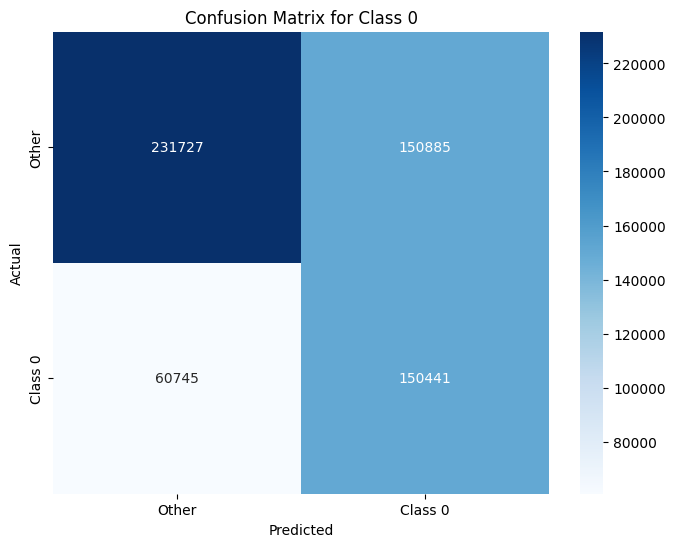


===== Feature Importance for Class 0 =====


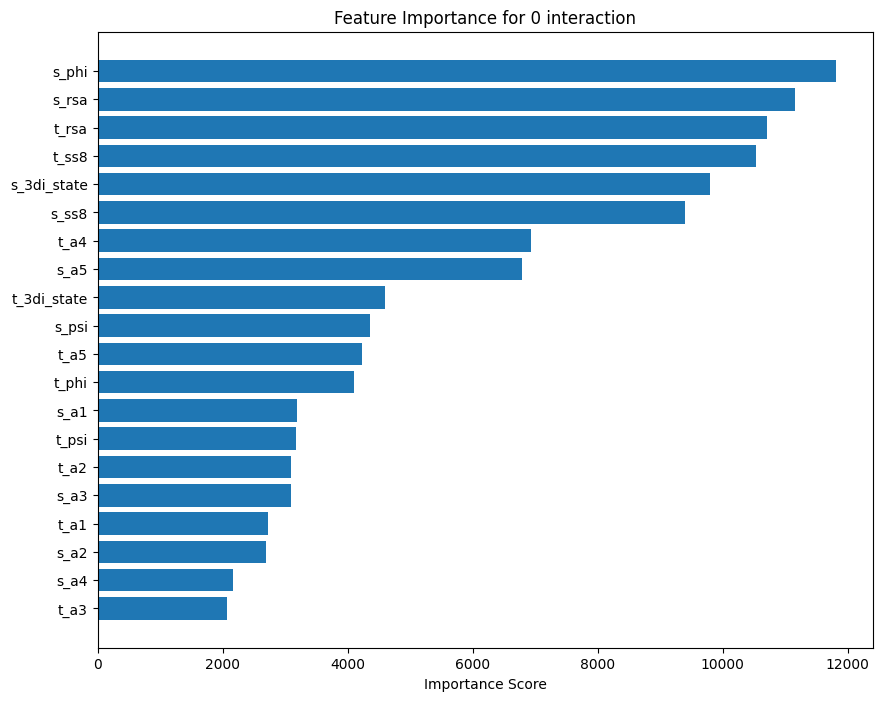

Training classifier for Class 1


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:59:12] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.54142	validation-error:0.48016	validation-aucpr:0.27554
[10]	validation-auc:0.55259	validation-error:0.49252	validation-aucpr:0.28245
[20]	validation-auc:0.55394	validation-error:0.49422	validation-aucpr:0.28334
[30]	validation-auc:0.55524	validation-error:0.49170	validation-aucpr:0.28428
[40]	validation-auc:0.55629	validation-error:0.48805	validation-aucpr:0.28502
[50]	validation-auc:0.55722	validation-error:0.48665	validation-aucpr:0.28569
[60]	validation-auc:0.55806	validation-error:0.48524	validation-aucpr:0.28626
[70]	validation-auc:0.55861	validation-error:0.48427	validation-aucpr:0.28657
[80]	validation-auc:0.55898	validation-error:0.48333	validation-aucpr:0.28676
[90]	validation-auc:0.55934	validation-error:0.48292	validation-aucpr:0.28703
[100]	validation-auc:0.55954	validation-error:0.48210	validation-aucpr:0.28717
[110]	validation-auc:0.55989	validation-error:0.48136	validation-aucpr:0.28742
[120]	validation-auc:0.56001	validation-error:0.48074	validatio

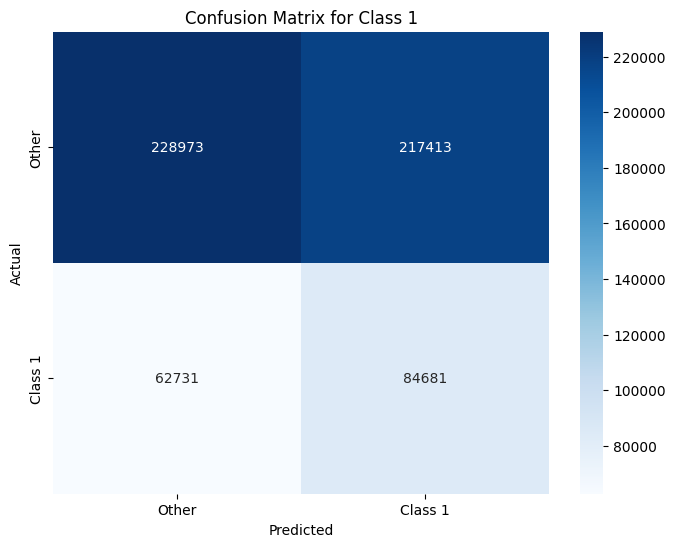


===== Feature Importance for Class 1 =====


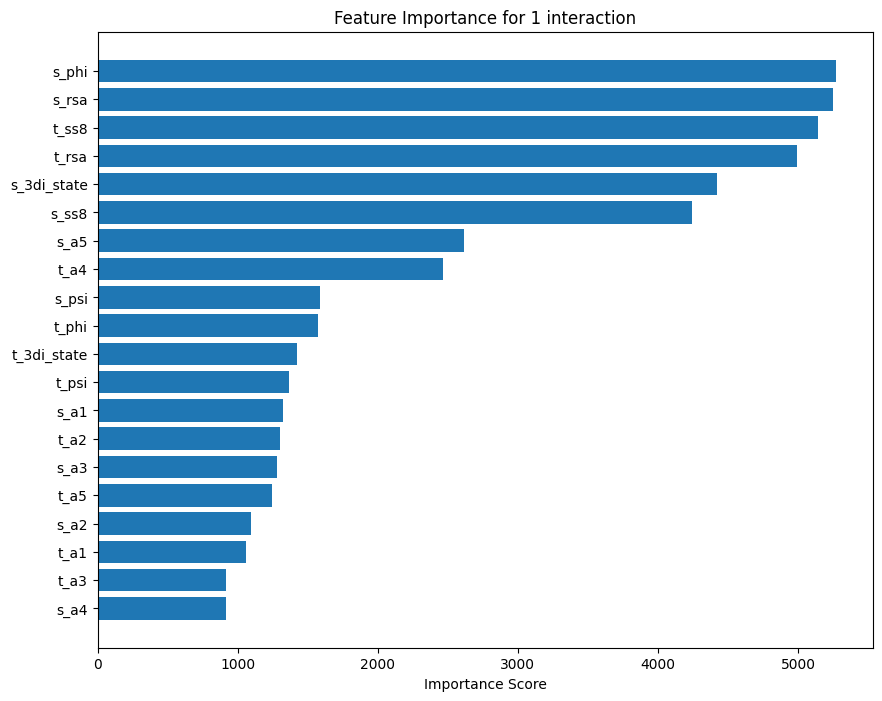

Training classifier for Class 2


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [17:59:47] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.95251	validation-error:0.09359	validation-aucpr:0.12105
[10]	validation-auc:0.98937	validation-error:0.02840	validation-aucpr:0.38247
[20]	validation-auc:0.98937	validation-error:0.02078	validation-aucpr:0.38247
[30]	validation-auc:0.98936	validation-error:0.02078	validation-aucpr:0.38241
[40]	validation-auc:0.98936	validation-error:0.02078	validation-aucpr:0.38241
[50]	validation-auc:0.98941	validation-error:0.02078	validation-aucpr:0.38365
[60]	validation-auc:0.98943	validation-error:0.02078	validation-aucpr:0.38389
[70]	validation-auc:0.98949	validation-error:0.02078	validation-aucpr:0.38533
[80]	validation-auc:0.98996	validation-error:0.02078	validation-aucpr:0.40027
[90]	validation-auc:0.98970	validation-error:0.02078	validation-aucpr:0.38912
[100]	validation-auc:0.99029	validation-error:0.02078	validation-aucpr:0.41569
[110]	validation-auc:0.99042	validation-error:0.02078	validation-aucpr:0.42844
[120]	validation-auc:0.99037	validation-error:0.02078	validatio

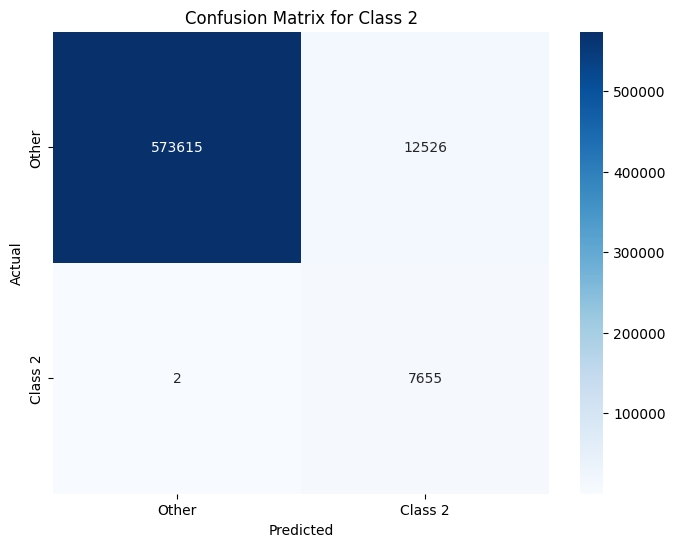


===== Feature Importance for Class 2 =====


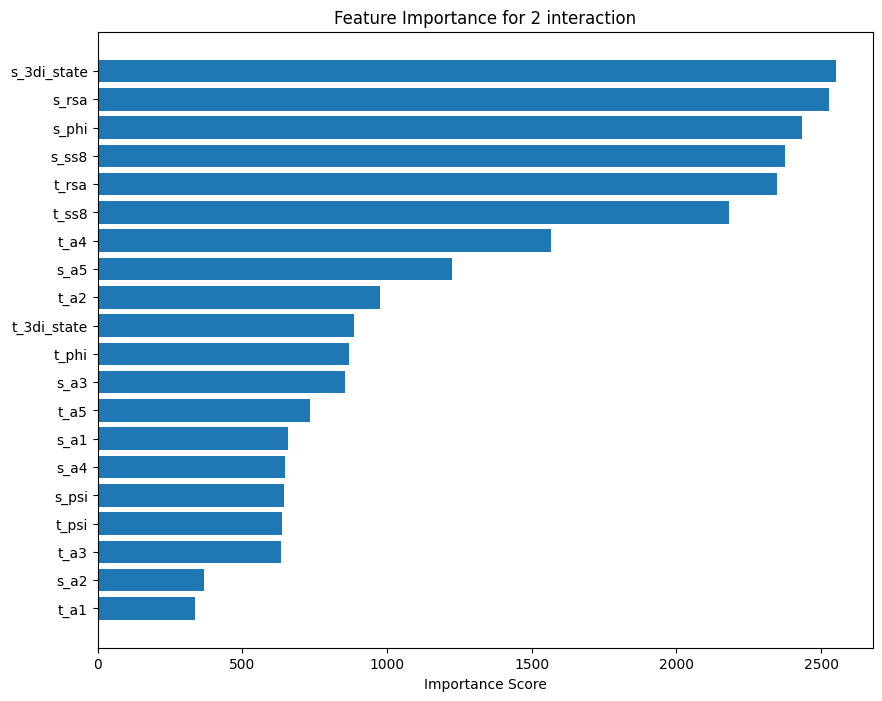

Training classifier for Class 3


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:00:55] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.93336	validation-error:0.13152	validation-aucpr:0.08309
[10]	validation-auc:0.96242	validation-error:0.08425	validation-aucpr:0.13900
[20]	validation-auc:0.96414	validation-error:0.08424	validation-aucpr:0.14510
[30]	validation-auc:0.97143	validation-error:0.08418	validation-aucpr:0.17829
[40]	validation-auc:0.97277	validation-error:0.08413	validation-aucpr:0.18774
[50]	validation-auc:0.97534	validation-error:0.08404	validation-aucpr:0.21450
[60]	validation-auc:0.97631	validation-error:0.08398	validation-aucpr:0.22714
[70]	validation-auc:0.97663	validation-error:0.08390	validation-aucpr:0.23264
[80]	validation-auc:0.97694	validation-error:0.08374	validation-aucpr:0.23589
[90]	validation-auc:0.97697	validation-error:0.08356	validation-aucpr:0.23681
[100]	validation-auc:0.97697	validation-error:0.08344	validation-aucpr:0.23658
[110]	validation-auc:0.97700	validation-error:0.08324	validation-aucpr:0.23732
[120]	validation-auc:0.97702	validation-error:0.08309	validatio

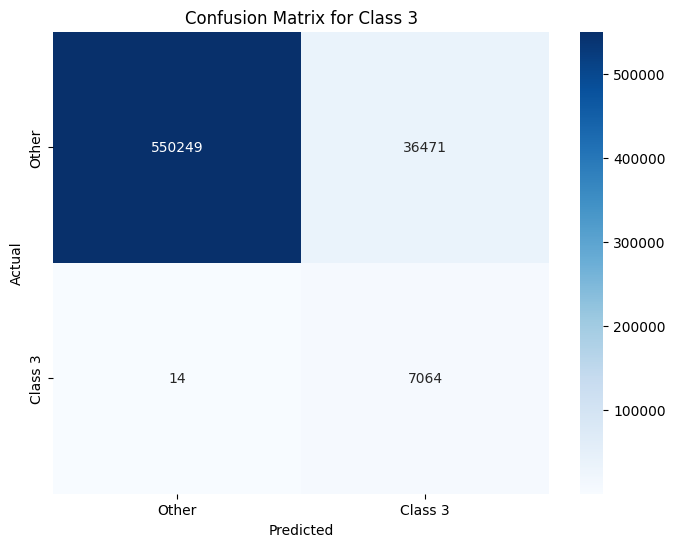


===== Feature Importance for Class 3 =====


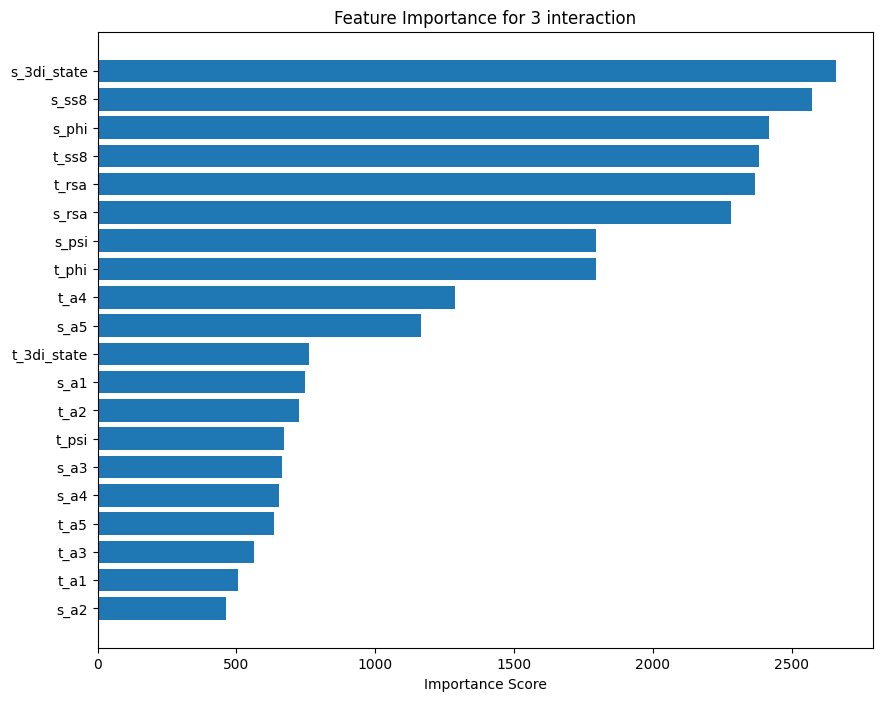

Training classifier for Class 4


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:01:54] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.91536	validation-error:0.16808	validation-aucpr:0.01748
[10]	validation-auc:0.97065	validation-error:0.09999	validation-aucpr:0.04937
[20]	validation-auc:0.97639	validation-error:0.10800	validation-aucpr:0.06124
[30]	validation-auc:0.98675	validation-error:0.09931	validation-aucpr:0.11047
[40]	validation-auc:0.98674	validation-error:0.09931	validation-aucpr:0.11048
[50]	validation-auc:0.98751	validation-error:0.10613	validation-aucpr:0.12295
[60]	validation-auc:0.98721	validation-error:0.09931	validation-aucpr:0.11313
[70]	validation-auc:0.98729	validation-error:0.09931	validation-aucpr:0.11355
[80]	validation-auc:0.98766	validation-error:0.09931	validation-aucpr:0.12146
[90]	validation-auc:0.98817	validation-error:0.09931	validation-aucpr:0.13748
[100]	validation-auc:0.98808	validation-error:0.09931	validation-aucpr:0.13988
[110]	validation-auc:0.98823	validation-error:0.09931	validation-aucpr:0.14115
[120]	validation-auc:0.98826	validation-error:0.09931	validatio

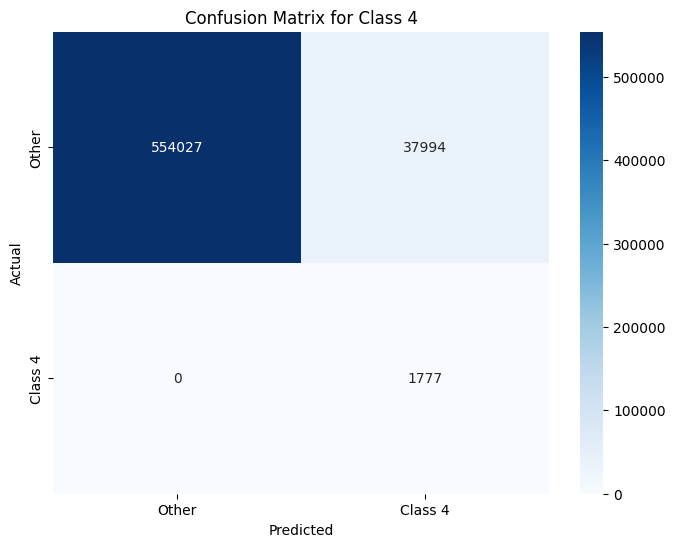


===== Feature Importance for Class 4 =====


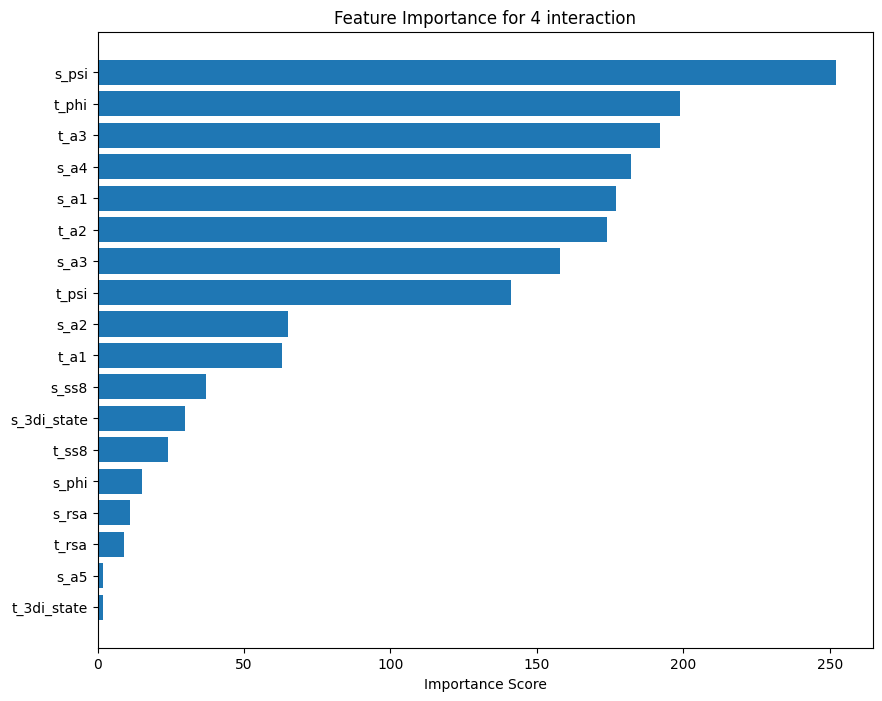

Training classifier for Class 5


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:02:11] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[10]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[20]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[30]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[40]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799
[49]	validation-auc:0.99944	validation-error:0.00112	validation-aucpr:0.38799

===== Performance Metrics for Class 5 =====
                        Value
Metric                       
Accuracy               0.9988
Balanced Accuracy      0.9994
AUC-ROC                0.9994
Matthews Correlation   0.6098
Average Precision      0.3723
Inference Time (ms)   32.9621


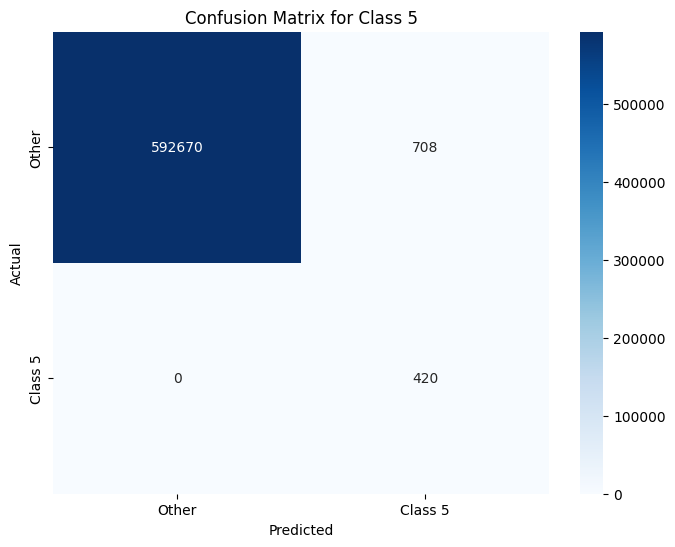


===== Feature Importance for Class 5 =====


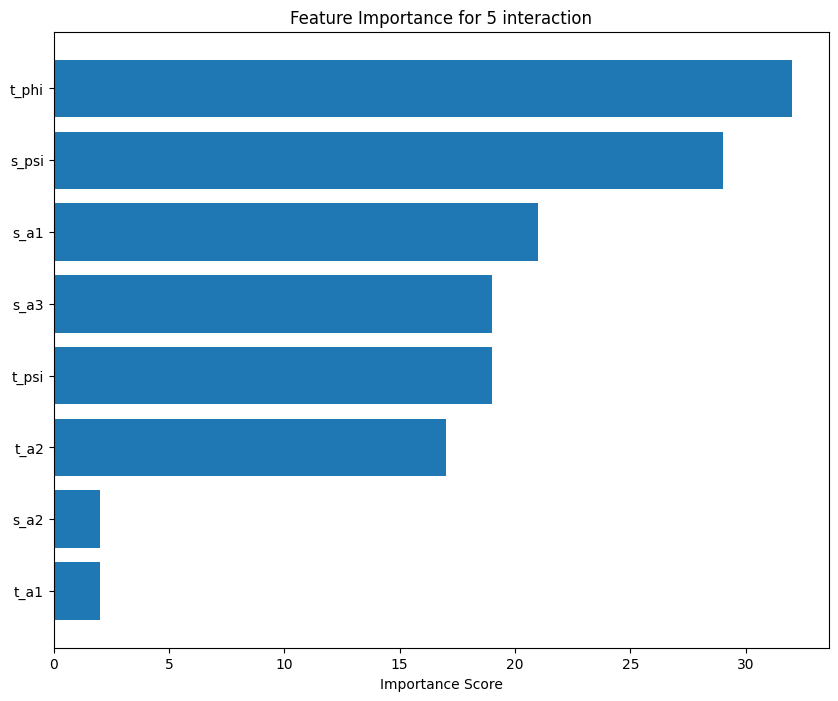

Training classifier for Class 6


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:02:15] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.85321	validation-error:0.29758	validation-aucpr:0.00295
[10]	validation-auc:0.93645	validation-error:0.15460	validation-aucpr:0.00635
[20]	validation-auc:0.93955	validation-error:0.15087	validation-aucpr:0.00726
[30]	validation-auc:0.94327	validation-error:0.15357	validation-aucpr:0.00837
[40]	validation-auc:0.94174	validation-error:0.15199	validation-aucpr:0.00827
[50]	validation-auc:0.94388	validation-error:0.15376	validation-aucpr:0.00910
[60]	validation-auc:0.94471	validation-error:0.15430	validation-aucpr:0.00923
[70]	validation-auc:0.94529	validation-error:0.15206	validation-aucpr:0.00971
[80]	validation-auc:0.94598	validation-error:0.15030	validation-aucpr:0.00999
[90]	validation-auc:0.94688	validation-error:0.14926	validation-aucpr:0.01037
[100]	validation-auc:0.94715	validation-error:0.14701	validation-aucpr:0.01114
[110]	validation-auc:0.94759	validation-error:0.14429	validation-aucpr:0.01128
[120]	validation-auc:0.94854	validation-error:0.14275	validatio

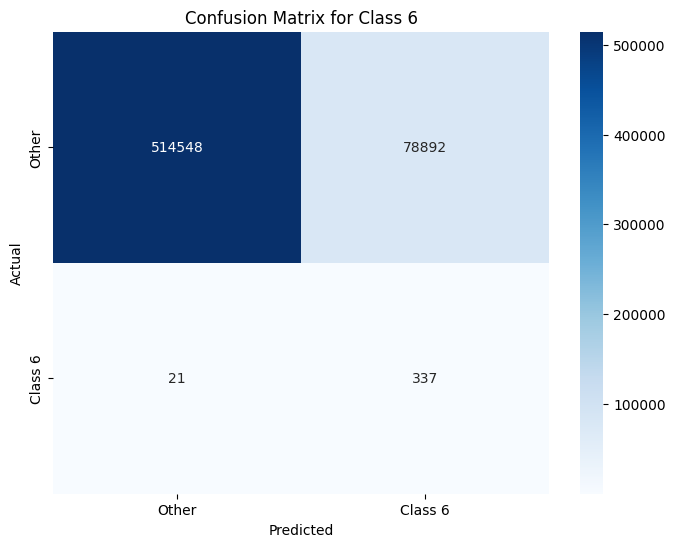


===== Feature Importance for Class 6 =====


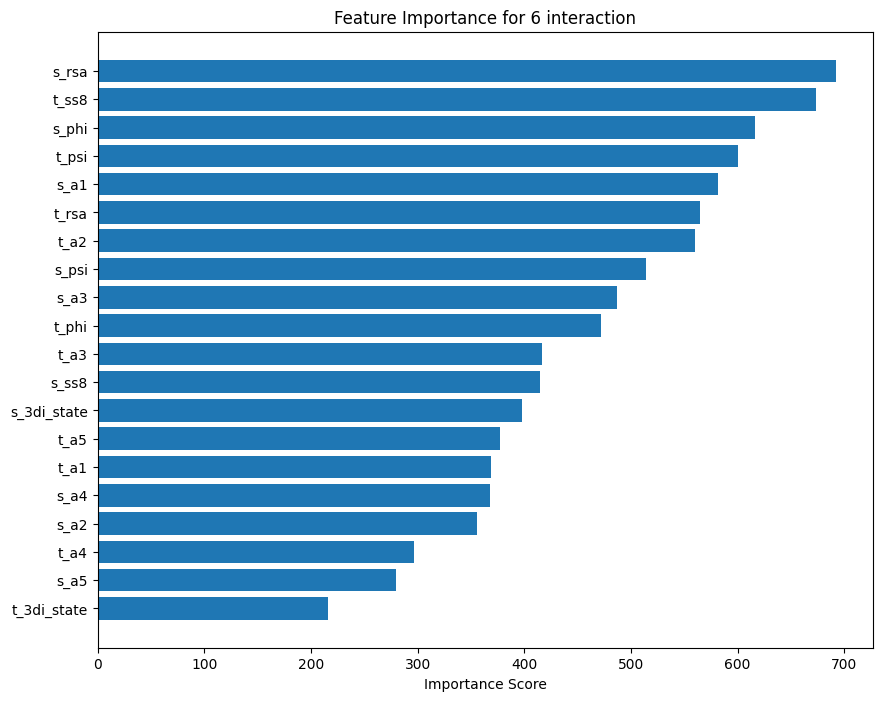

Training classifier for Class 7


/Users/sebastianosanson/Development/Contacts-Classification/sb_project/lib/python3.12/site-packages/xgboost/callback.py:386: UserWarning: [18:02:44] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  self.starting_round = model.num_boosted_rounds()


[0]	validation-auc:0.63332	validation-error:0.41118	validation-aucpr:0.49124
[10]	validation-auc:0.67015	validation-error:0.37946	validation-aucpr:0.53510
[20]	validation-auc:0.68049	validation-error:0.37150	validation-aucpr:0.54623
[30]	validation-auc:0.68950	validation-error:0.36188	validation-aucpr:0.55585
[40]	validation-auc:0.69601	validation-error:0.35639	validation-aucpr:0.56266
[50]	validation-auc:0.70044	validation-error:0.35198	validation-aucpr:0.56729
[60]	validation-auc:0.70391	validation-error:0.34918	validation-aucpr:0.57125
[70]	validation-auc:0.70694	validation-error:0.34722	validation-aucpr:0.57438
[80]	validation-auc:0.70982	validation-error:0.34505	validation-aucpr:0.57722
[90]	validation-auc:0.71136	validation-error:0.34365	validation-aucpr:0.57912
[100]	validation-auc:0.71277	validation-error:0.34280	validation-aucpr:0.58066
[110]	validation-auc:0.71502	validation-error:0.34117	validation-aucpr:0.58318
[120]	validation-auc:0.71779	validation-error:0.33890	validatio

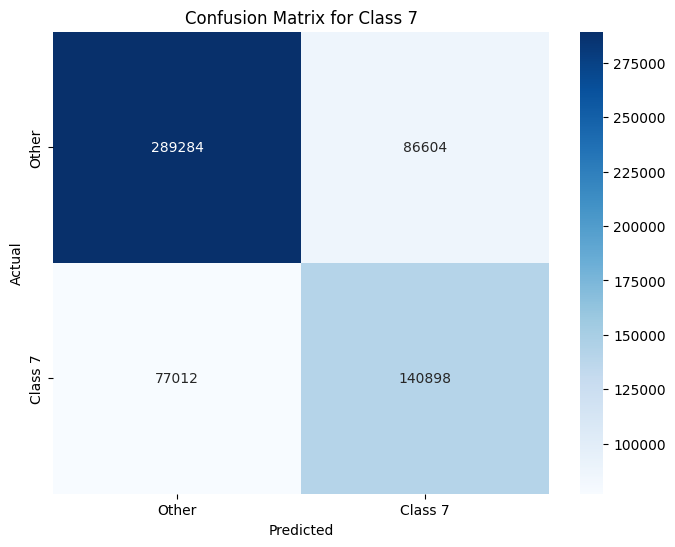


===== Feature Importance for Class 7 =====


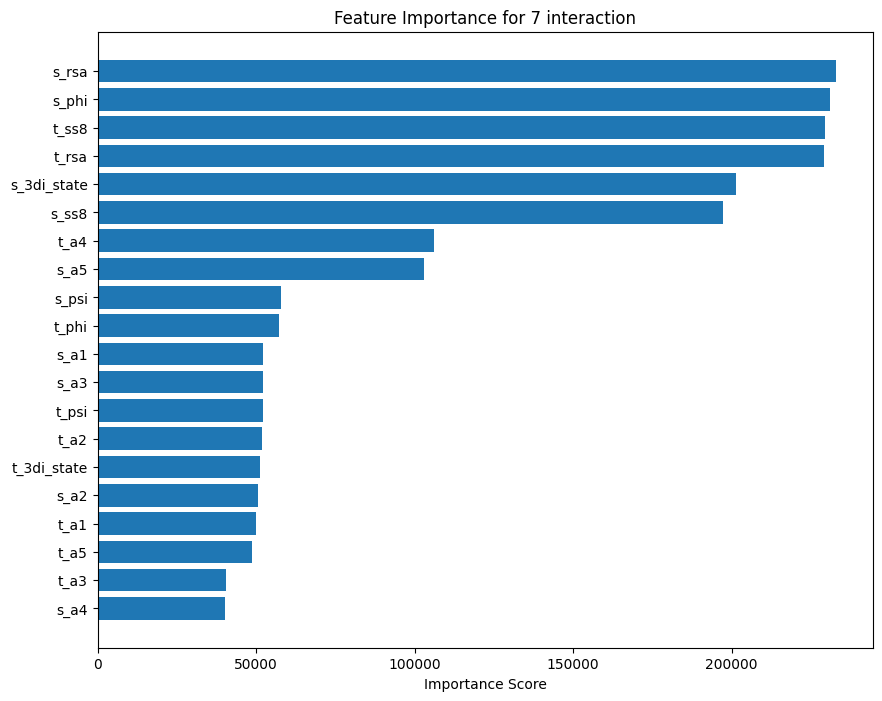

In [ ]:
# Create arrays to store models and predictions
models = []
all_class_predictions = np.zeros((len(y_test), len(np.unique(y_train))))

# For each class, train a binary classifier
for num_class in range(len(np.unique(y_train))):
    print(f'Training classifier for Class {num_class}')

    # Create binary labels for ALL training examples
    # 1 for current class, 0 for all other classes
    y_train_binary = (y_train == num_class).astype(int)
    y_val_binary = (y_val == num_class).astype(int)

    # weights_train = compute_sample_weight('balanced', y_train)
    # weights_val = compute_sample_weight('balanced', y_val)

    # Create DMatrix objects
    dtrain = xgb.DMatrix(X_train, label=y_train_binary)
    dval = xgb.DMatrix(X_val, label=y_val_binary)

    # Count num negative/positive examples for this class
    neg_count = np.sum(y_train_binary == 0)
    pos_count = np.sum(y_train_binary == 1)
    scale_pos_weight = neg_count / pos_count if pos_count > 0 else 1.0

    # Get base params
    params = {
        'device': 'cuda',
        'seed': 42,
        'objective': 'binary:logistic',
        'eval_metric': ['auc', 'error', 'aucpr'],
        'max_delta_step': 1
    }

    # Update with class-specific params
    params.update(class_params[num_class])
    params['scale_pos_weight'] = scale_pos_weight
        
    model = xgb.train(
        params = params,
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=10
    )

    # Save model
    os.makedirs(os.path.join(path, 'models/bin_models'), exist_ok=True)
    model.save_model(os.path.join(path, f'models/bin_models/xgboost_model_class_{num_class}.json'))

    evaluate_model(model, X_test, y_test, num_class, feature_names)

    # Store the model
    models.append(model)

## Combines models

In [14]:
from collections import defaultdict


class UnifiedXGBoostEnsemble:
    """Unified model that combines multiple binary XGBoost models"""

    def __init__(self, models_dir):
        """Load all models from the directory"""
        self.models = []
        self.models_dir = models_dir

        # Load models in order by class number
        for class_num in range(8):  # Assuming 8 classes
            model_path = os.path.join(models_dir, f"xgboost_model_class_{class_num}.json")
            if os.path.exists(model_path):
                model = xgb.Booster()
                model.load_model(model_path)
                self.models.append(model)

        self.n_classes = len(self.models)
        print(f"Successfully loaded {self.n_classes} models from {models_dir}")

    def predict_proba(self, X):
        """Get probability predictions from all models"""
        dtest = xgb.DMatrix(X)
        probas = []

        for model in self.models:
            # Get class probability from each model
            proba = model.predict(dtest)
            probas.append(proba)

        # Stack into a samples x classes matrix
        return np.column_stack(probas)

    def predict(self, X):
        """Make final predictions using max probability"""
        probas = self.predict_proba(X)
        probas_normalized = probas / np.sum(probas, axis=1, keepdims=True)

        return np.argmax(probas_normalized, axis=1)

def aggregate_feature_importance(models):
    """Aggregate feature importance scores across multiple models"""
    all_importances = defaultdict(list)
    
    # Collect importances from all models
    for model in models:
        importances = model.get_score(importance_type='weight')
        for feature, score in importances.items():
            all_importances[feature].append(score)
    
    # Compute mean importance for each feature
    mean_importances = {}
    for feature, scores in all_importances.items():
        mean_importances[feature] = sum(scores) / len(scores)
    
    return mean_importances

def evaluate_unified_ensemble(model, X_test, y_test, class_names=None):
    """
    Evaluate the unified ensemble with comprehensive metrics
    """
    if class_names is None:
        class_names = [f"Class {i}" for i in range(model.n_classes)]

    print("\n===== Evaluating Unified Ensemble (Max Probability) =====\n")

    # Get predictions and probabilities
    y_pred = model.predict(X_test)
    probas = model.predict_proba(X_test)

    # Calculate overall metrics
    metrics = {
        'Metric': [
            'Accuracy',
            'Balanced Accuracy',
            'Matthews Correlation Coefficient'
        ],
        'Value': [
            accuracy_score(y_test, y_pred),
            balanced_accuracy_score(y_test, y_pred),
            matthews_corrcoef(y_test, y_pred)
        ]
    }

    # Print overall metrics
    metrics_df = pd.DataFrame(metrics)
    print("Overall Metrics:")
    print(metrics_df.set_index('Metric').round(4))

    # Calculate per-class metrics
    roc_aucs = []
    avg_precisions = []

    print("\nPer-Class Metrics:")
    for i in range(model.n_classes):
        # Binary encoding for this class
        y_true_bin = (y_test == i).astype(int)
        y_score = probas[:, i]

        # ROC AUC
        roc_auc = roc_auc_score(y_true_bin, y_score)
        roc_aucs.append(roc_auc)

        # Average Precision
        avg_prec = average_precision_score(y_true_bin, y_score)
        avg_precisions.append(avg_prec)

        print(f"{class_names[i]}: ROC AUC = {roc_auc:.4f}, Avg Precision = {avg_prec:.4f}")

    print(f"\nMacro-Average ROC AUC: {np.mean(roc_aucs):.4f}")
    print(f"Macro-Average Precision: {np.mean(avg_precisions):.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix - Unified Ensemble')
    plt.show()

    # compute feature importance for the unified ensemble
    feature_importance = aggregate_feature_importance(model.models)
    feature_importance = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
    features, scores = zip(*feature_importance)     
    plt.figure(figsize=(10, 8))
    plt.barh(features, scores)
    plt.xlabel('Importance Score')
    plt.title('Feature Importance - Unified Ensemble')
    plt.gca().invert_yaxis()  # To show the most important feature on top
    plt.show()

    return {
        'accuracy': metrics['Value'][0],
        'balanced_accuracy': metrics['Value'][1],
        'matthews_corr': metrics['Value'][2],
        'roc_auc_per_class': roc_aucs,
        'avg_precision_per_class': avg_precisions,
        'predictions': y_pred,
        'probabilities': probas
    }

Successfully loaded 8 models from models/bin_models

===== Evaluating Unified Ensemble (Max Probability) =====

Overall Metrics:
                                   Value
Metric                                  
Accuracy                          0.4681
Balanced Accuracy                 0.6736
Matthews Correlation Coefficient  0.2673

Per-Class Metrics:
HBOND: ROC AUC = 0.7193, Avg Precision = 0.5583
VDW: ROC AUC = 0.5624, Avg Precision = 0.2886
PIPISTACK: ROC AUC = 0.9910, Avg Precision = 0.4440
IONIC: ROC AUC = 0.9783, Avg Precision = 0.2451
PICATION: ROC AUC = 0.9891, Avg Precision = 0.1370
SSBOND: ROC AUC = 0.9994, Avg Precision = 0.3723
PIHBOND: ROC AUC = 0.9589, Avg Precision = 0.0136
Unclassified: ROC AUC = 0.7826, Avg Precision = 0.6613

Macro-Average ROC AUC: 0.8726
Macro-Average Precision: 0.3400


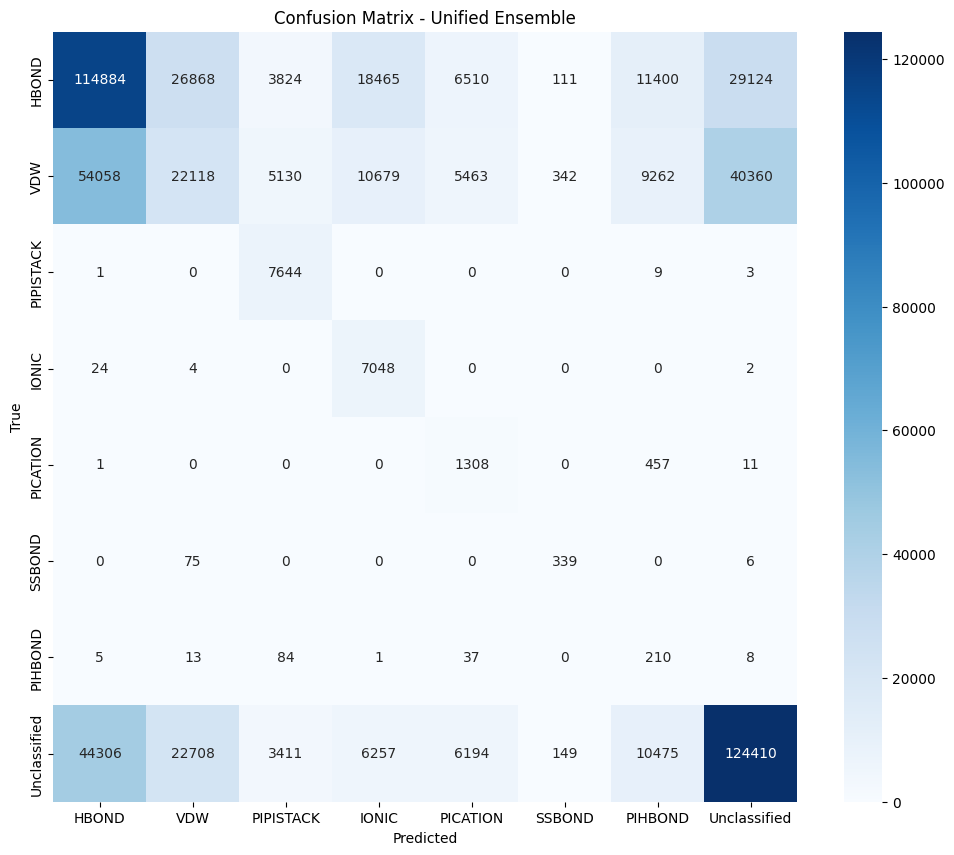

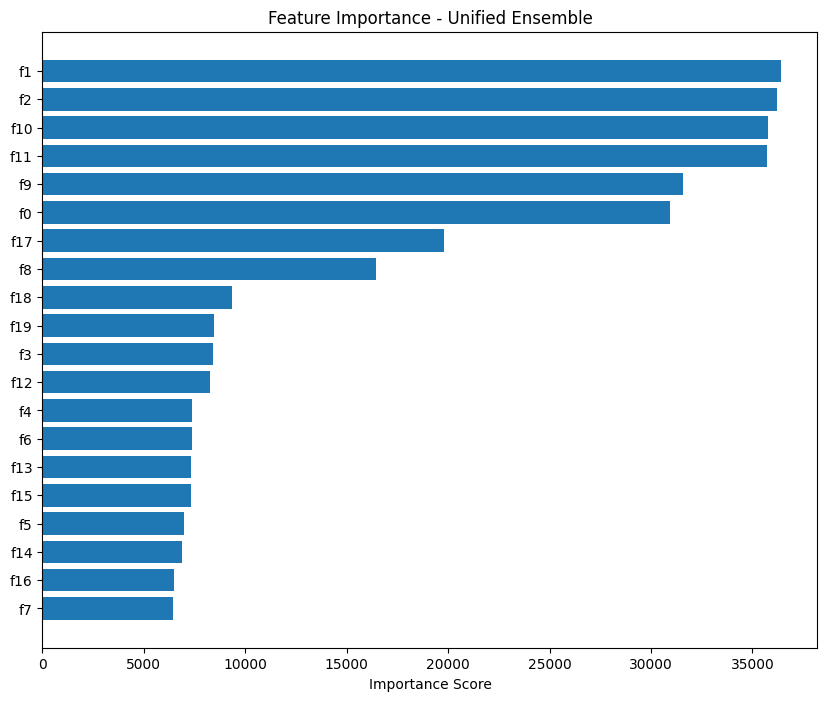

In [15]:
models_dir = 'models/bin_models'
class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]

# Create and evaluate the unified model
unified_model = UnifiedXGBoostEnsemble(models_dir)
results = evaluate_unified_ensemble(unified_model, X_test, y_test, class_names)

## Features selection

For unified model

In [ ]:
from collections import defaultdict

def feature_selection_for_unified_model(model_dir, X_train, y_train, X_test, y_test, feature_names, threshold_method='mean'):
    """
    Perform feature selection for UnifiedXGBoostEnsemble by aggregating feature importance
    from all binary models.
    
    Parameters:
    -----------
    model_dir: str
        Directory containing the binary model files
    X_train, y_train: numpy arrays
        Training data
    X_test, y_test: numpy arrays
        Test data
    feature_names: list
        Names of all features
    threshold_method: str
        Method to determine threshold ('mean', 'median', or float value)
    """
    # Load all binary models
    models = []
    for class_num in range(8):  # Assuming 8 classes
        model_path = os.path.join(model_dir, f"xgboost_model_class_{class_num}.json")
        if os.path.exists(model_path):
            model = xgb.Booster()
            model.load_model(model_path)
            models.append(model)
    
    print(f"Loaded {len(models)} binary models from {model_dir}")
    
    # Aggregate feature importance across all models
    aggregated_importance = defaultdict(float)
    
    for model in models:
        importance = model.get_score(importance_type='weight')
        for feature, score in importance.items():
            feature_idx = int(feature.replace('f', ''))
            aggregated_importance[feature_idx] += score
    
    # Convert to list of (feature_idx, importance) tuples
    importance_list = [(idx, score) for idx, score in aggregated_importance.items()]
    importance_list.sort(key=lambda x: x[1], reverse=True)
    
    # Calculate threshold based on method
    importance_values = np.array([score for _, score in importance_list])
    if threshold_method == 'mean':
        threshold = np.mean(importance_values)
    elif threshold_method == 'median':
        threshold = np.median(importance_values)
    elif isinstance(threshold_method, float):
        threshold = threshold_method
    else:
        threshold = np.mean(importance_values)  # Default to mean
    
    print(f"Feature importance threshold: {threshold:.4f}")
    
    # Select features above threshold
    selected_indices = [idx for idx, score in importance_list if score > threshold]
    
    # If no features selected, use top 10
    if not selected_indices:
        print("No features above threshold, using top 10 instead")
        selected_indices = [idx for idx, _ in importance_list[:10]]
    
    # Ensure indices are within valid range
    selected_indices = [idx for idx in selected_indices if idx < X_train.shape[1]]
    
    print(f"Selected {len(selected_indices)} features out of {X_train.shape[1]}")
    
    # Display selected feature names if available
    if feature_names:
        selected_names = [feature_names[idx] for idx in selected_indices]
        print("Selected features:")
        for idx, name in zip(selected_indices, selected_names):
            print(f"  - {name} (index: {idx})")
    
    # Plot aggregate feature importance
    plt.figure(figsize=(12, 8))
    if feature_names:
        top_features = [(feature_names[idx], score) for idx, score in importance_list[:20]]
        features, scores = zip(*top_features)
    else:
        top_features = importance_list[:20]
        features = [f"Feature {idx}" for idx, _ in top_features]
        scores = [score for _, score in top_features]
    
    plt.barh(features, scores)
    plt.xlabel('Aggregated Importance Score')
    plt.title('Top Features by Aggregated Importance')
    plt.gca().invert_yaxis()  # Most important at the top
    plt.axvline(x=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Filter data to only include selected features
    X_train_selected = X_train[:, selected_indices]
    X_val_selected = X_val[:, selected_indices]
    X_test_selected = X_test[:, selected_indices]
    
    # Train new binary models with selected features
    new_models = []
    
    for class_num in range(8):
        print(f"Training pruned model for Class {class_num} with selected features")
        
        # Create binary labels
        y_train_binary = (y_train == class_num).astype(int)
        y_val_binary = (y_val == class_num).astype(int)

        # Compute sample weights for training and validation
        weights_train = compute_sample_weight('balanced', y_train_binary)
        weights_val = compute_sample_weight('balanced', y_val_binary)
        
        # Create DMatrix with selected features
        dtrain = xgb.DMatrix(X_train_selected, label=y_train_binary, weight=weights_train)
        dval = xgb.DMatrix(X_val_selected, label=y_val_binary, weight=weights_val)
        
        # Count positive/negative examples
        # pos_class = np.sum(y_train_binary == 1)
        # neg_class = np.sum(y_train_binary == 0)
        # scale_pos_weight = neg_class / pos_class if pos_class > 0 else 1.0
        
        # Train pruned model
        pruned_model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': ['auc', 'error'],
            'max_depth': 15,
            'learning_rate': 0.02,
            'subsample': 0.8,
            'colsample_bytree': 0.7,
            'gamma': 0.2,
            'reg_alpha': 0.3,
            'reg_lambda': 1.5,
            'min_child_weight': 3
        },
        dtrain=dtrain,
        num_boost_round=5000,
        evals=[(dval, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=50
    )
        
        new_models.append(pruned_model)
        
        # Save pruned model
        os.makedirs(os.path.join('models', 'unified_pruned'), exist_ok=True)
        pruned_model.save_model(os.path.join('models', 'unified_pruned', f'xgboost_model_class_{class_num}.json'))
    
    # Create and evaluate the pruned unified model
    class PrunedUnifiedXGBoostEnsemble:
        def __init__(self, models, selected_indices):
            self.models = models
            self.selected_indices = selected_indices
            self.n_classes = len(models)
            
        def predict_proba(self, X):
            # Filter features first
            X_selected = X[:, self.selected_indices]
            dtest = xgb.DMatrix(X_selected)
            probas = []
            
            for model in self.models:
                proba = model.predict(dtest)
                probas.append(proba)
            
            return np.column_stack(probas)
            
        def predict(self, X):
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
    
    # Create the pruned unified model
    pruned_unified_model = PrunedUnifiedXGBoostEnsemble(new_models, selected_indices)
    
    print("\nEvaluating pruned unified model...")
    
    # If the evaluate_unified_ensemble function is available, use it
    try:
        class_names = ["HBOND", "VDW", "PIPISTACK", "IONIC", "PICATION", "SSBOND", "PIHBOND", "Unclassified"]
        results = evaluate_unified_ensemble(pruned_unified_model, X_test, y_test, class_names)
    except:
        # Simple evaluation if the full function isn't available
        y_pred = pruned_unified_model.predict(X_test)
        accuracy = np.mean(y_pred == y_test)
        print(f"Pruned model accuracy: {accuracy:.4f}")
    
    return pruned_unified_model, selected_indices



In [ ]:
pruned_model, selected_features = feature_selection_for_unified_model(
    'models/bin_models', 
    X_train, y_train, 
    X_test, y_test, 
    feature_names
)

For binary classifiers

In [ ]:
models_dir = 'models/bin_models'
model_files = [f for f in os.listdir(models_dir) if f.startswith('xgboost_model_class_') and f.endswith('.json')]
model_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

for filename in model_files:
    model_path = os.path.join(models_dir, filename)
    model = xgb.Booster()
    model.load_model(model_path)

    # Get feature importances as a dictionary
    importance = model.get_score(importance_type='weight')

    # Extract the importance values and calculate their mean using numpy
    # Handle case where importance dictionary might be empty
    if importance:
        importance_values = np.array(list(importance.values()))
        threshold = np.mean(importance_values)
    else:
        print(f"Warning: No feature importance scores found for model {filename}. Skipping feature selection.")
        continue # Skip feature selection and training for this model

    # Create a dictionary mapping original feature indices to importance scores
    # XGBoost's get_score returns f0, f1, f2... if no feature_names are provided
    # Need to handle the case where feature_names might not have been passed to DMatrix
    # Assuming importance keys are 'f0', 'f1', ... corresponding to column indices 0, 1, ...
    # We will create a dummy feature importance structure that SelectFromModel can use
    # SelectFromModel requires a model with a `feature_importances_` or `coef_` attribute
    # We can create a dummy model-like object or use SelectFromModel directly with the scores

    # A better approach for SelectFromModel with xgb.Booster is to manually apply the threshold

    # Get features sorted by importance
    sorted_importance = sorted(importance.items(), key=lambda item: item[1], reverse=True)

    # Select features based on the threshold
    selected_feature_indices = [int(key[1:]) for key, score in sorted_importance if score > threshold]

    if not selected_feature_indices:
        print(f"Warning: No features selected for model {filename} with threshold {threshold}. Skipping training for this model.")
        continue # Skip training if no features are selected

    # Ensure selected_feature_indices are within the bounds of X_train columns
    max_feature_index = X_train.shape[1] - 1
    selected_feature_indices = [idx for idx in selected_feature_indices if idx <= max_feature_index]

    if not selected_feature_indices:
        print(f"Warning: Selected feature indices out of bounds for model {filename}. Skipping training.")
        continue

    # Filter data using selected indices
    X_train_selected = X_train[:, selected_feature_indices]
    X_val_selected = X_val[:, selected_feature_indices] 
    X_test_selected = X_test[:, selected_feature_indices]

    # Get the original feature names if available (assuming 'feature_names' is accessible from previous cells)
    # This part might need adjustment based on how 'feature_names' was defined and used
    try:
        selected_features_names = [feature_names[idx] for idx in selected_feature_indices]
        print(f"Selected features: {selected_features_names}")
    except NameError:
         print(f"Selected feature indices: {selected_feature_indices}")
         print("Cannot retrieve feature names: 'feature_names' variable not found.")


    # Train a new model with selected features
    # We need to train a new XGBoost model (XGBClassifier or xgb.train)
    # The original code used xgb.train, let's stick to that for consistency with DMatrix

    # Assuming y_train and y_test are still the original multi-class labels
    # For the SelectFromModel approach as originally intended, you might need to train a
    # multi-class XGBClassifier or handle binary classification within this loop

    # Let's assume the goal is still binary classification per class for pruning
    # Need the corresponding binary labels for training and testing

    # Get the class number from the filename
    class_num = int(filename.split('_')[-1].split('.')[0])
    y_train_binary = (y_train == class_num).astype(int)
    y_val_binary = (y_val == class_num).astype(int)
    y_test_binary = (y_test == class_num).astype(int)

    dtrain_selected = xgb.DMatrix(X_train_selected, label=y_train_binary)
    dval_selected = xgb.DMatrix(X_val_selected, label=y_val_binary)
    dtest_selected = xgb.DMatrix(X_test_selected, label=y_test_binary)

    # Recalculate scale_pos_weight for the potentially reduced dataset (though SMOTE makes it balanced)
    # pos_class_selected = np.sum(y_train_binary == 1)
    # neg_class_selected = np.sum(y_train_binary == 0)
    # scale_pos_weight_selected = neg_class_selected / pos_class_selected if pos_class_selected > 0 else 1.0

    

    # Train the pruned model
    pruned_model = xgb.train(
        params = {
            'device': 'cuda',
            'seed': 42,
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': 15,
            'learning_rate': 0.03,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'gamma': 0.1,
            'reg_alpha': 0.1,
            'reg_lambda': 1.0,
            'max_delta_step': 0,  # Helps imbalance
        },
        dtrain=dtrain_selected,
        num_boost_round=model.best_iteration + 1 if hasattr(model, 'best_iteration') else 100, # Use best_iteration from original model or a fixed number,
        evals=[(dval_selected, 'validation')],
        early_stopping_rounds=50,
        verbose_eval=100
    )

    evaluate_model(pruned_model, X_test_selected, y_test, class_num, selected_features_names, selected_feature_indices=selected_feature_indices)

    # Save the pruned model
    os.makedirs(os.path.join(path, 'models/bin_models_pruned_mean_threshold'), exist_ok=True)
    pruned_model.save_model(os.path.join(path, f'models/bin_models_pruned_mean_threshold/fs_model_class_{class_num}.json'))